In [5]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('plots/paper.mplstyle')

import seaborn as sns

from scipy.optimize import curve_fit

#https://docs.scipy.org/doc/scipy/reference/odr.html


from scipy.odr import Model, RealData, ODR

In [6]:
res = pd.read_csv("results/2022_05_all_runs.csv")
ms = pd.read_csv("results/2022_05_all_mean_stds.csv")

In [7]:
def linfit(x, m, b):
    return m * x + b

def second_order_pol(x, p1, p2, p3):
    return p1 * x**2 + p2 * x + p3

def latfit(b0, x):
    mu, sig = x
    a, b, c, d, e = b0
    return  a *  mu**2 + b * mu + c * sig**2 + d * sig +  e

def latfit_err(b0err, x):
    mu, sig = x
    ar, br, cr, dr, er = b0err
    return np.sqrt((mu**2 * ar)**2 + (br * mu)**2 + (cr * sig**2)**2 + (dr * sig)**2 + er**2)

/tmp/ipykernel_1061829/2191690879.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mono["minflares"] = mono.nflares.apply(lambda x: float(x.split("-")[0]))
/tmp/ipykernel_1061829/2191690879.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mono["maxflares"] = mono.nflares.apply(lambda x: float(x.split("-")[-1]))
/tmp/ipykernel_1061829/2191690879.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

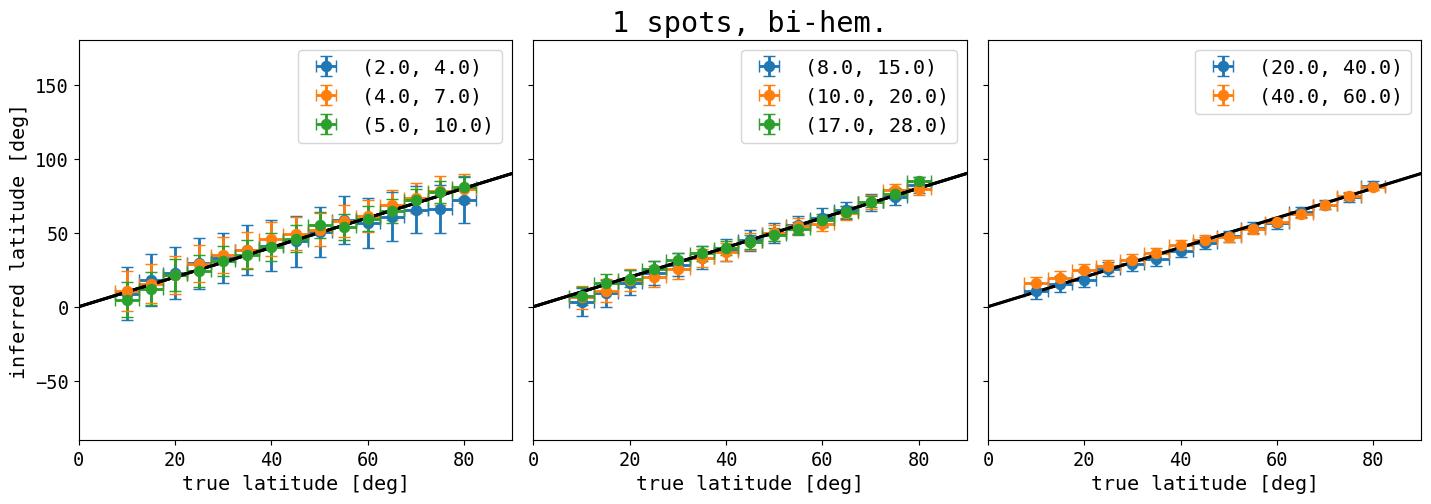

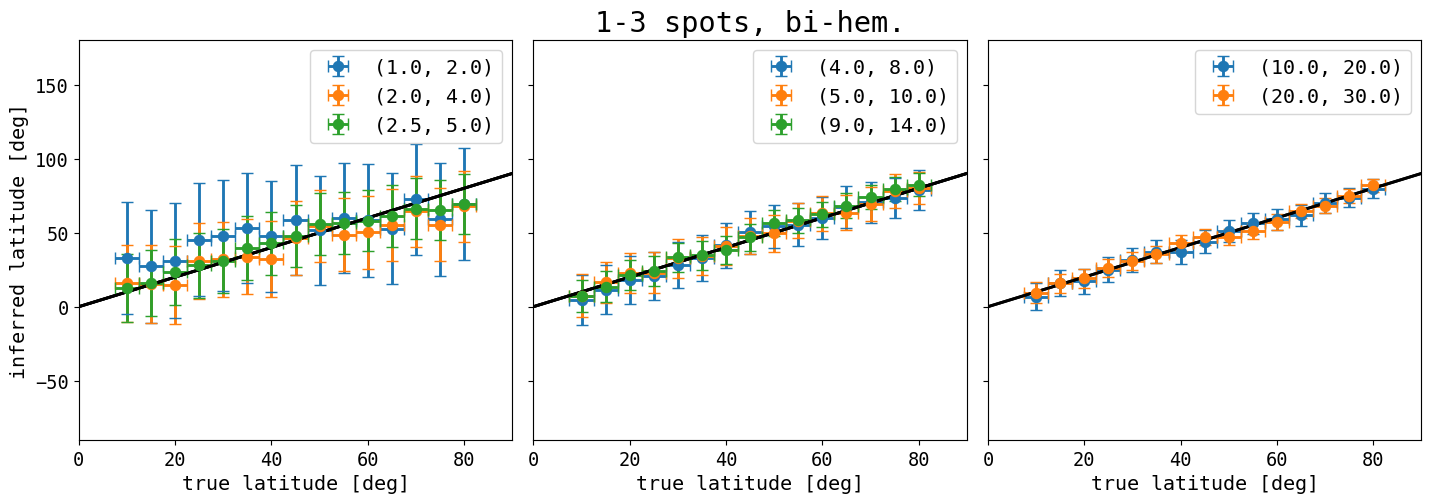

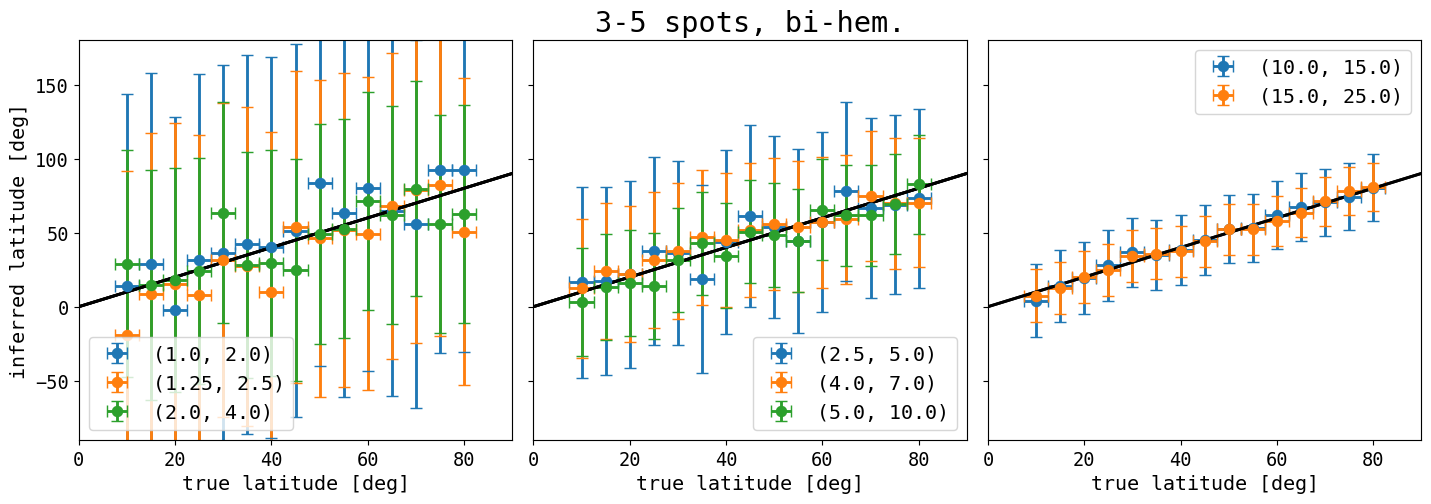

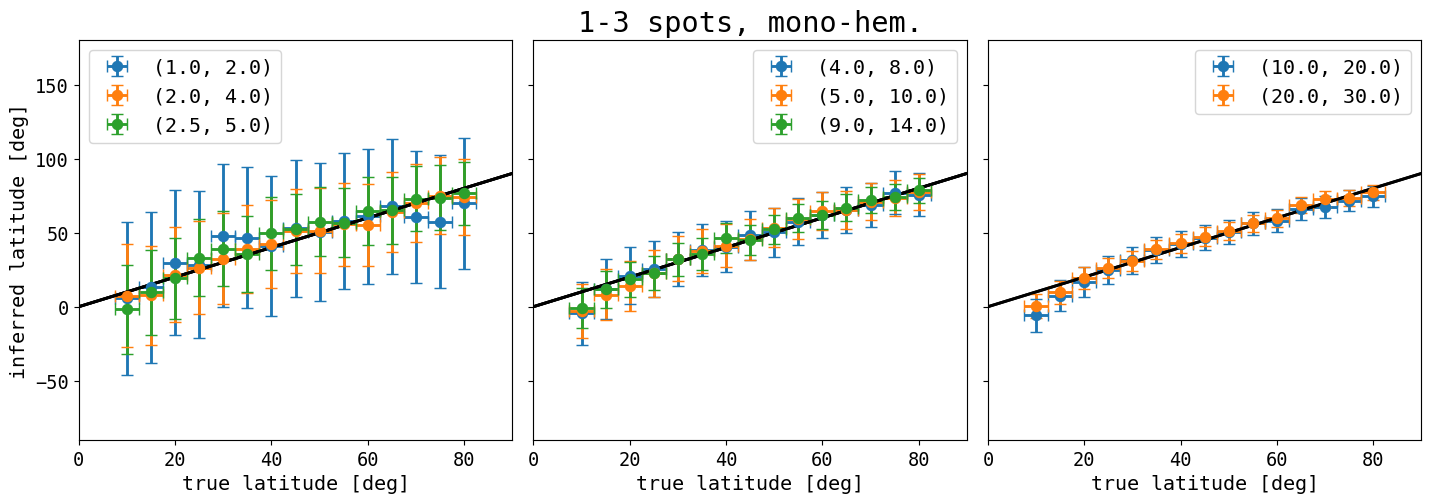

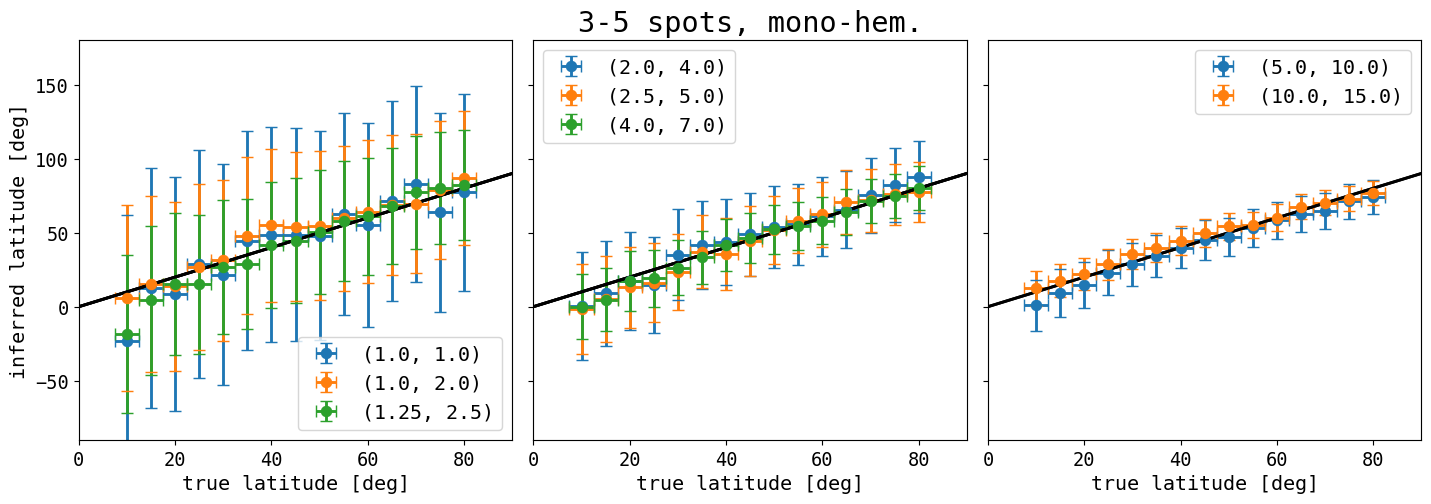

In [8]:
fitres = {}

for color in ms.c.unique():
    # select hemisphere + spot number subset
    mono= ms[ms.c == color]
    
    # make a label for this subset
    tt = f"{mono.nspots.iloc[0]} spots, {mono.hem.iloc[0]}"
    
    # init a Model for this subset
    f = Model(latfit)
    
    # first x-data: mean of waiting times and the mean of waiting time std
    x = np.array([mono.mean_of_wtd_means.values,
                  mono.mean_of_wtd_stds.values])
    
    # second x-data: std of waiting time mean and std of waiting time std
    sx = np.array([mono.std_of_wtd_means.values,
                   mono.std__of_wtd_stds.values])
    
    # y-data: the latitudes
    y = mono.latitude.values
    sy = np.full_like(y, 2.5)
    
    # init data for ODR fit
    # see also https://docs.scipy.org/doc/scipy/reference/generated/scipy.odr.RealData.html#scipy.odr.RealData
    mydata = RealData(x, y, sx=sx, sy=sy)

    # ODR fit
    myodr = ODR(mydata, f, 
                beta0=[-1788.8766187, 1627.4705935, 
                       -1562.95810747, 1181.56885256, 82.],
                maxit=15000)
    myoutput = myodr.run()

    
    # cast the number of flares per active region in two columns instead of one
    mono["minflares"] = mono.nflares.apply(lambda x: float(x.split("-")[0]))
    mono["maxflares"] = mono.nflares.apply(lambda x: float(x.split("-")[-1]))
    
    # sort subset data
    mono = mono.sort_values("minflares",ascending=True)
    
    # init dict for the results
    fitres[tt]={}
    
    # fill in results from fit with fit parameters and their uncertainties
    fitres[tt]=dict(zip(["color","a","b","c","d","e","ar","br","cr","dr","er"],
                        np.concatenate(([mono.c.iloc[0]], myoutput.beta, myoutput.sd_beta))))

    # PLOT THE RESULTS
    axes = [0,0,0,1,1,1,2,2]
    fig, AX = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharey=True)
    
    # loop over flare activity regeimes as quantified by minflares/maxflares
    ax_activity = list(zip(axes, mono.groupby(["minflares", "maxflares"])))
    for ax, (label, g) in ax_activity:
        
        # mean values
        x = np.array([g.mean_of_wtd_means.values,
                      g.mean_of_wtd_stds.values])
        
        # true latitudes
        y = g.latitude.values
        
        # true latitude vs. fitted latitude
        AX[ax].errorbar(y, latfit(myoutput.beta,x),
                        xerr=2.5, yerr=latfit_err(myoutput.sd_beta, x),
                        label=label, fmt="o", markersize=7,
                        alpha=1, capsize=4)
        # axis layout
        AX[ax].plot([0,90],[0,90],c="k")
        AX[ax].set_xlim(0,90)
        AX[ax].set_ylim(-90,180)
        AX[ax].set_xlabel("true latitude [deg]")
        AX[ax].legend();
    
    # shared y-label
    AX[0].set_ylabel("inferred latitude [deg]")
    
    # title
    AX[1].set_title(f"{mono.nspots.iloc[0]} spots, {mono.hem.iloc[0]}",fontsize=20)
    
    # tight layout
    plt.tight_layout()
    
#     plt.savefig(f"plots/{mono.nspots.iloc[0]}_spots_{mono.hem.iloc[0]}_fit_5params".replace("-","_").replace(".",""),dpi=300)

In [9]:
# put results in a DataFrame
fitresd = pd.DataFrame(fitres)


,"1 spots, bi-hem.","1-3 spots, bi-hem.","3-5 spots, bi-hem.","1-3 spots, mono-hem.","3-5 spots, mono-hem."
color,#E69F00,#CC79A7,#230072B2,#56B4E9,#009E73
a,-2153.6712889553132,-2899.154166152671,-17175.52950434724,-5937.98640970156,-14846.5864564946
b,1741.0833079149984,3612.3083608094566,15330.205812690607,5195.223215148674,10016.254082483574
c,536.5934353232333,-4056.9928223325096,-7788.619879297908,-3809.472051268241,3390.1201047707864
d,-1720.3379077648572,-2665.4534847492714,-11710.28112523767,-3841.8023375538455,-8606.918421438539
e,84.6001623702019,45.59882985591217,-73.83621627842632,26.73755820181245,-27.63407190434783
ar,129.18217633942453,266.21468342598826,1218.5376601794417,421.5641903062656,665.9781591845131
br,30.81513660966421,61.63977703329087,358.899851042569,105.57338379836071,202.90289552397508
cr,215.61035037408303,503.86352771713524,1894.1499769344377,727.0967982210828,1042.8344458042443
dr,44.2852444511934,83.72977052456137,320.77725805694615,110.97124960115113,189.73706127088698


In [10]:
fitresd.to_csv("results/fit_parameters.csv")

# Now cross-validate

In [11]:
fitresd = pd.read_csv("results/fit_parameters.csv")
fitresd = fitresd.set_index("Unnamed: 0")
fitresd

,"1 spots, bi-hem.","1-3 spots, bi-hem.","3-5 spots, bi-hem.","1-3 spots, mono-hem.","3-5 spots, mono-hem."
Unnamed: 0,,,,,
color,#E69F00,#CC79A7,#230072B2,#56B4E9,#009E73
a,-2153.6712889553132,-2899.154166152671,-17175.52950434724,-5937.98640970156,-14846.5864564946
b,1741.0833079149984,3612.3083608094566,15330.205812690607,5195.223215148674,10016.254082483574
c,536.5934353232333,-4056.9928223325096,-7788.619879297908,-3809.472051268241,3390.1201047707864
d,-1720.3379077648572,-2665.4534847492714,-11710.28112523767,-3841.8023375538455,-8606.918421438539
e,84.6001623702019,45.59882985591217,-73.83621627842632,26.73755820181245,-27.63407190434783
ar,129.18217633942453,266.21468342598826,1218.5376601794417,421.5641903062656,665.9781591845131
br,30.81513660966421,61.63977703329087,358.899851042569,105.57338379836071,202.90289552397508
cr,215.61035037408303,503.86352771713524,1894.1499769344377,727.0967982210828,1042.8344458042443


In [13]:

# cycle over each set of results, but pick only 1-spot fit for now
for case, color in fitresd.T.color[0:1].iteritems():

    # pick up the synthetic data again
    sets = res[res.color == color]
    
    # for each fit, create a table
    tab = {}
    
    # define a set of colors for each cross-validation with the fit
    colors = ['#17becf', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']
    
    # cycle over all parametrizations
    for c, col in list(zip(colors, fitresd)):
        
        # select each fit
        column = fitresd[col]
        
        # get fit parameters
        params = column[list("abcde")].values.astype(float)
        paramerrs = column[["ar", "br", "cr", "dr", "er"]].values.astype(float)
        
        # init inferred, true and err on latitutes
        inflats, truelats, inflatserr = [],[],[]
        
        # init counter
        i=0
        
        # for each case, each interpretation gets a subtable
        tab[col] = {}
        
        # cycle over the data sets with different flare activity ranges
        for s, row in sets.iterrows():
            
            # for each interpretation add VALIDATION data set that was NOT used for the fit
            string = f"results/{row.tstamp[17:]}_flares_validate_merged.csv"
            df = pd.read_csv(string)#.iloc[::5]
            
            # get mean and std of waiting time
            x = df[["diff_tstart_mean_stepsize1",
                    "diff_tstart_std_stepsize1"]] / 2. / np.pi
            
            # what would be the inferred values for those synthetic pairs?
            df["inferred_lat"] = latfit(params, x.values.T)
            df["inferred_lat_err"] = latfit_err(paramerrs, x.values.T)
            
            # if the fit is out of range, drop it
            df.loc[df["inferred_lat"] > 90.,"inferred_lat"] = np.nan
            df.loc[df["inferred_lat"] < 0.,"inferred_lat"] = np.nan
            
            # if the error rendern the result uninformative, drop it
            df.loc[df["inferred_lat_err"] > 90.,"inferred_lat"]=np.nan
            
            # concatenate the results for this flare activity level with the over levels
            inflats = np.concatenate((inflats, df.inferred_lat.values))
            inflatserr = np.concatenate((inflatserr, df.inferred_lat_err.values))
            truelats = np.concatenate((truelats,df.midlat2.values))
            
        # for this fit, add crossvalidation results to the table
        tab[col]["truelat"] = truelats
        tab[col]["inflat"] = inflats
        tab[col]["inflat_err"] = inflatserr
        
    # reshape table
    reform = {(outerKey, innerKey): values for outerKey, innerDict in tab.items() 
                                           for innerKey, values in innerDict.items()}

    ff = pd.DataFrame(reform)

In [15]:
# manually select the table where 1-spot is fit to 1-spot
fff = ff.T.reset_index().drop([3,4,5,7,8,10,11,13,14,6,9,12]).dropna(subset=[1], axis=1)
fff = fff.replace("1 spots, bi-hem.","1 spot")
fff

,level_0,level_1,0,1,2,3,4,5,6,7,...,269,270,271,272,273,274,275,276,277,278
0,1 spot,truelat,3.733500,6.092500,8.451500,10.810500,13.169500,15.528500,17.887500,20.246500,...,64.42300,66.851000,69.279000,71.707000,74.135000,76.563000,78.991000,81.419000,83.847500,86.276000
1,1 spot,inflat,8.871604,6.875798,17.663907,17.649065,26.148830,18.107896,26.014822,34.867287,...,61.74871,78.842007,62.030639,53.544282,67.844257,77.709571,54.283437,69.727641,69.497343,56.328240
2,1 spot,inflat_err,4.686025,4.751383,4.289874,4.239031,3.939613,4.316759,3.948045,3.614959,...,16.79561,13.754896,15.307803,17.066715,15.195551,15.719744,17.988679,16.933444,15.594078,16.545677


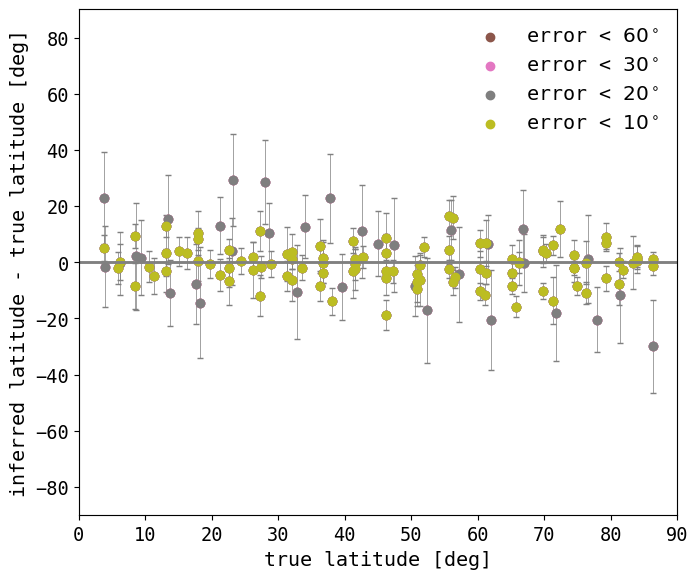

In [16]:
colors = ['#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']
plt.figure(figsize=(7.5,6.5))
ffff = fff.drop(["level_0","level_1"],axis=1)
truelat = ffff.iloc[0][::-2]
inflat = ffff.iloc[1][::-2]
inflaterr = ffff.iloc[2][::-2]

plt.errorbar(x=truelat, y=inflat-truelat, yerr=inflaterr,fmt="o",
             markersize=0,linewidth=0.5,capsize=2,c="grey",zorder=-10)
for err,c in list(zip([60,30,20,10],colors)):
    ins = inflaterr < err
#     print(err, inflaterr[ins])
    plt.scatter(x=truelat[ins], y=inflat[ins]-truelat[ins],s=34,c=c, label=fr"error < ${err}^\circ$")    
plt.plot([0,90],[0,0],c="grey")
plt.xlabel("true latitude [deg]")
plt.ylabel("inferred latitude - true latitude [deg]")
plt.ylim(-90,90)
plt.xlim(0,90)
plt.legend(frameon=False)
plt.savefig("plots/residuals_1spot_grouped.png");

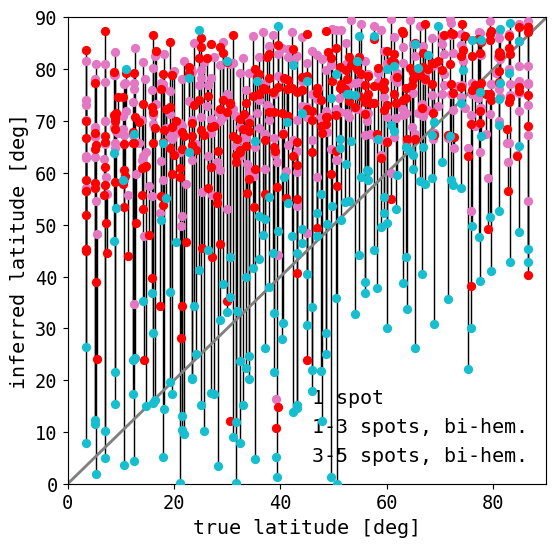

In [47]:
colors = ['#17becf', 'red', '#e377c2']
plt.figure(figsize=(6,6))
for i in fff:
    if i in range(0,333):
        
#         plt.scatter(fff[0], fff[i][1:],c="k",marker="o",s=10)
        plt.plot([fff[i][0]]*3, fff[i][1:],c="k",linewidth=1)
        
        
for i, row in fff[1:].iterrows():
    plt.scatter(fff.iloc[0].iloc[2:],row.iloc[2:],s=30,zorder=10,c=colors.pop(),label=row["level_0"])
    
plt.plot([0,90],[0,90],c="grey")
plt.xlabel("true latitude [deg]")
plt.ylabel("inferred latitude [deg]")
plt.ylim(0,90)
plt.xlim(0,90)
plt.legend(frameon=False);

In [48]:
fitresd.loc["color",:].values, fitresd.loc["color",:].index

(array(['#E69F00', '#CC79A7', '#230072B2', '#56B4E9', '#009E73'],
       dtype=object),
 Index(['1 spots, bi-hem.', '1-3 spots, bi-hem.', '3-5 spots, bi-hem.',
        '1-3 spots, mono-hem.', '3-5 spots, mono-hem.'],
       dtype='object'))